# Square Gradient Theory for Mixtures

This notebook has te purpose of showing examples of computing interfacial tension of mixtures and beta != 0.

First it's needed to import the necessary modules

In [1]:
import numpy as np
from phasepy import component, mixture, prsveos
from phasepy.equilibrium import bubblePy
from phasepy.sgt import sgt_mix, msgt_mix
import matplotlib.pyplot as plt

Then the mixture and EoS are created. The bubble point of the mixture of x1 = 0.3 at 320K is computed. The ```full_output``` option allows to obtain the compositions, densities and equilibrium pressure.

In [2]:
hexane = component(name = 'n-Hexane', Tc = 507.6, Pc = 30.25, Zc = 0.266, Vc = 371.0, w = 0.301261, 
                ksv = [ 0.81185833, -0.08790848],
                cii = [ 5.03377433e-24, -3.41297789e-21,  9.97008208e-19],
                GC = {'CH3':2, 'CH2':4})

ethanol = component(name = 'Ethanol', Tc = 514.0, Pc = 61.37, Zc = 0.241, Vc = 168.0, w = 0.643558,
                ksv = [1.27092923, 0.0440421 ],
                cii = [ 2.35206942e-24, -1.32498074e-21,  2.31193555e-19],
                GC = {'CH3':1, 'CH2':1, 'OH(P)':1})

mix = mixture(ethanol, hexane)

a12, a21 = np.array([1141.56994427,  125.25729314])
A = np.array([[0, a12], [a21, 0]])
mix.wilson(A)

eos = prsveos(mix, 'mhv_wilson')

T = 320 #K
X = np.array([0.3, 0.7])
P0 = 0.3 #bar
Y0 = np.array([0.7, 0.3])

sol = bubblePy(Y0, P0, X, T, eos, full_output = True)
Y = sol.Y
P = sol.P
vl = sol.v1
vv = sol.v2

#computing the density vector
rhol = X / vl
rhov = Y / vv

In order to set the beta correction is necessary to create the matrix and then use it with the  ```beta_sgt``` method from the eos. If this step is not done the ```sgt_mix``` or ```msgt_sgt``` function will raise an error as the influence parameter matrix will be singular. 

In [3]:
bij = 0.1
beta = np.array([[0, bij], [bij, 0]])
eos.beta_sgt(beta)

The first possibility is to solve the BVP iteratively using ortoghonal collocation. The initial interfacial lenght is set to 10 Amstrong and the density profiles are solved, then the interfacial lenght is increased until the calculated interfacial tension doesnt change more than a given tolerance.

The initial value can be set as ```'linear'``` or ```'hyperbolic'``` to use a linear or a hyperbolic approximation. Optionally a array can be passed to the argument ```rho0``` or a TensionResult for another calculation, as for example, the density profile computed with beta0 calculation.

In [4]:
sol = sgt_mix(rhol, rhov, T, P, eos, z0 = 10,  rho0 = 'hyperbolic', full_output = True)

C:\Users\gustavo\Documents\phasepy\phasepy\cubic\cubicmix.py:450: RuntimeWarning: invalid value encountered in log
  mui += -Tad*np.log(Prefa/(Tad*roa))+Tad


In [5]:
sol.tension
sol.rho
sol.z
sol.GPT

array([0.00000000e+00, 3.58052643e-08, 9.84830120e-07, 5.89238684e-06,
       2.04063728e-05, 5.48437142e-05, 1.34655653e-04, 3.48053772e-04,
       1.02920029e-03, 3.06517319e-03, 7.01194889e-03, 1.10239854e-02,
       1.32779240e-02, 1.30488849e-02, 1.03701432e-02, 6.58032831e-03,
       3.29548016e-03, 1.29483240e-03, 3.90166908e-04, 7.56974611e-05,
       3.53563954e-06, 0.00000000e+00])

The other option is to used a modified SGT system which includes a temporal variable which help to reach the stationary density profile ignoring the non linearity of the BVP at the first iterations. This type of computation use a fixed value for the interfacial lenght.

The initial value options to solve the density profiles are the same as for ```sgt_mix```. In this case the previously computed TensionResult is used as an initial guess.

In [6]:
solm = msgt_mix(rhol, rhov, T, P, eos, z = 20, rho0 = sol, full_output = True)

In [7]:
print('BVP SGT : ', sol.tension, 'mN/m')
print('Modified BVP SGT : ', solm.tension, 'mN/m')

BVP SGT :  14.36781328594585 mN/m
Modified BVP SGT :  14.367827924919165 mN/m


Finally the density profiles can be compared. It can be seen that when a correction to the cross influence parameter just one stationary point across the interface.

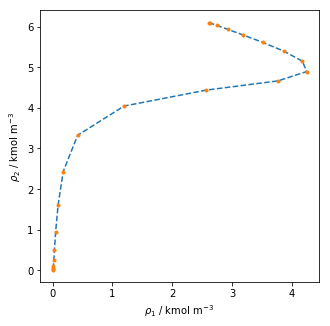

In [25]:
#conver densitites to kmol/m3
rho = sol.rho * 1000
rhom = solm.rho * 1000 

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.plot(rho[0], rho[1], '--')
ax.plot(rhom[0], rhom[1], '.')
ax.set_xlabel(r'$\rho_1$ / kmol m$^{-3}$ ')
ax.set_ylabel(r'$\rho_2$ / kmol m$^{-3}$ ')